# Generate training data for exercises
 >__Created__:  2020


In [1]:
import os, sys
import numpy as np
import joblib as jb
import scipy.stats as st 
import pandas as pd
# standard modules for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt

import corner
%matplotlib inline

In [3]:
# update fonts
FONTSIZE = 18
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)
mp.rc('xtick', labelsize='x-small')
mp.rc('ytick', labelsize='x-small')
#mp.rc('text', usetex=True)

In [4]:
def generate(mu, cov, N, target):
    d  = st.multivariate_normal.rvs(mu, cov, N)
    X  = [x for x, y in d]
    Y  = [y for x, y in d]
    T  = np.zeros(N) if target < 0.5 else np.ones(N)
    df = pd.DataFrame({'target': T, 'x': X, 'y': Y})
    return df

### Generate data for class with $t = 0$

In [5]:
N   = 15000
mu  = np.array([-1.0, 1.0])
cov = np.array([[ 0.8, 0.0],
                [ 0.0, 0.8]])
b1  = generate(mu, cov, N, 0)

In [6]:
N   = 15000
mu  = np.array([1.0,-1.0])
cov = np.array([[ 0.8, 0.0],
                [ 0.0, 0.8]])
b2  = generate(mu, cov, N, 0)
bkg = b1.append(b2)

### Generate data for class with $t = 1$

In [7]:
N   = 15000
mu  = np.array([-1.0, -1.0])
cov = np.array([[ 0.8, 0.0],
                [ 0.0, 0.8]])
s1  = generate(mu, cov, N, 1)

In [8]:
N   = 15000
mu  = np.array([1.0, 1.0])
cov = np.array([[ 0.8, 0.0],
                [ 0.0, 0.8]])
s2  = generate(mu, cov, N, 1)
sig = s1.append(s2)

### Create a single data set with $all$ rows randomly shuffled

In [9]:
data = bkg.append(sig)
# frac=1 => all rows
# reset_index(drop=True) => drop original indices and create new ones
data = data.sample(frac=1).reset_index(drop=True)

# save data
jb.dump(data, 'data_01.db')
data[:10]

,target,x,y
0,0.0,-1.462965,2.426415
1,0.0,0.316226,-1.726901
2,0.0,-2.716621,0.390152
3,0.0,0.835977,-2.415027
4,0.0,1.594806,-2.201238
5,0.0,2.251994,-0.009178
6,1.0,1.117939,-0.094264
7,0.0,-2.651078,-1.876610
8,1.0,0.561020,-0.137487
9,0.0,-2.327774,1.308989


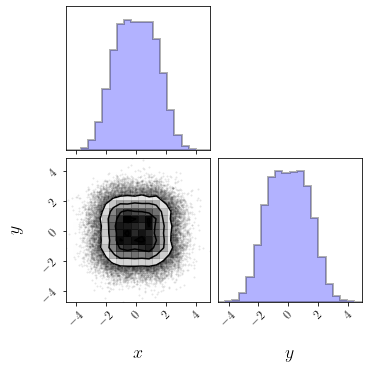

In [14]:
fig = corner.corner(data[['x', 'y']], 
                    labels=['$x$', '$y$'],
                    fill_contours=False,
                    hist_kwargs={'histtype': 'stepfilled',
                                 'linewidth': 2,
                                 'edgecolor': 'black', 
                                 'facecolor': 'blue', 
                                 'alpha': 0.3})

In [12]:
def plot_data(df, N=4000):
    sig = df[df.target > 0.5][:N]
    bkg = df[df.target < 0.5][:N]
    
    # create an empty figure
    fig = plt.figure(figsize=(5, 5))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)
    ax.set_xlabel('$x$', fontsize=FONTSIZE)
    ax.set_ylabel('$y$', fontsize=FONTSIZE)
    
    ax.scatter(sig['x'], sig['y'], c='b', s=1, alpha=0.5, label='$t = 1$')
    ax.scatter(bkg['x'], bkg['y'], c='r', s=1, alpha=0.5, label='$t = 0$')

    ax.grid(True, which="both", linestyle='-')
    ax.legend(loc='upper right')

    plt.show()

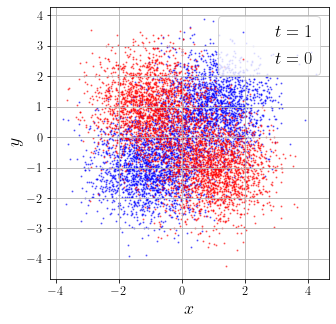

In [15]:
plot_data(data)

### Generate 1D data

In [16]:
N  = 50000
x  = np.random.uniform(-1, 1, N)

# targets
t = 3 * np.exp(-x/2) * np.sin(10*x)**2 + 2*np.cos(6*x) - 1.5

In [17]:
df = pd.DataFrame({'target': t, 'x': x})
jb.dump(df, 'data_02.db')
df[:5]

,target,x
0,-3.105658,-0.629914
1,0.606763,0.836369
2,-3.043396,0.591139
3,0.212389,0.953277
4,0.895618,0.040388


In [18]:
def plot_1d(x, t):
    
    # create an empty figure
    fig = plt.figure(figsize=(5, 5))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)
    ax.scatter(x, t, c='b', s=5)
    ax.set_xlabel('$x$', fontsize=FONTSIZE)
    ax.set_ylabel('$t$', fontsize=FONTSIZE)
    ax.grid(True, which="both", linestyle='-')
    plt.show()

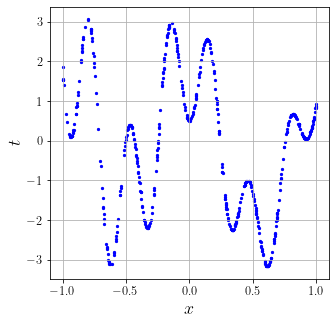

In [19]:
M = 500
plot_1d(x[:M], t[:M])